In [1]:
from config import setup, import_and_display_fnc
setup()

# Near-field evaluation via quadrature by expansion (QBX). 

## An intro to QBX.

### Near-field evaluation
When working with boundary integral methods, it's common to need to evaluate surface integrals like:

\begin{equation}
u(\mathbf{p}) = \int_{S} K(\mathbf{p}, \mathbf{q}) \phi(\mathbf{q}) d\mathbf{q}
\end{equation}

where $K(\mathbf{p}, \mathbf{q})$ is normally a fundamental solution to a PDE or the derivative thereof. At a basic level, these integrals are hard because $K$ is singular. Depending on the dimension and problem, the singularity will be something like $\log(r)$ or $\frac{1}{r^n}$ where $r = \|\mathbf{p}-\mathbf{q}\|_2$. 

If $\mathbf{p}$ is far away from $S$, then the integral is very smooth and well-behaved and can be super easily computed with standard quadrature rules like Gaussian quadrature or the trapezoidal rule. But, if $\mathbf{p}$ is close to some part of $S$, then the singularity in $K(\mathbf{p},\mathbf{q})$ makes computation of the integral hard. In the boundary integral literature, this is called the **near-field evaluation problem**. Or in the case where $\mathbf{p} \in S$, the **singular evaluation problem**.

The brute force solution to the problem is to just compute the integral with a very high order quadrature rule or an adaptive quadrature rule. For the near-field case, using a higher order quadrature order will eventually converge to the correct value but the number of quadrature points will grow prohibitively large as $\mathbf{p}$ approaches $S$. However, for the singular evaluation problem, some integrals will not converge at all. Many approaches have been developed to handle these singular and near-singular integrals (CITE a few?).

### QBX

A robust and general solution to nearfield evaluation is a method called quadrature by expansion (**QBX**). The basic idea is to form an approximation for $u(\mathbf{p})$ "centered" at a point $\mathbf{c}$ away from $S$ and then use that proxy to extrapolate to points that are close to $S$. There are several versions of QBX depending on the type of proxy used:

* The [original QBX paper](https://arxiv.org/abs/1207.4461){cite:p}`Klckner2013` uses a separation of variables technique for the Helmholtz equation to form a series expansion in terms of Hankel functions and Bessel functions. This works for other PDEs if some separation of variables techniques are known. With Poisson and elasticity, we'd probably use polar expansions in 2D and spherical harmonic expansions in 3D.
* The [quadrature by kernel-independent expansion (QBKIX) paper](https://arxiv.org/abs/1612.00977){cite:p}`Rahimian2017` forms a proxy set of point sources which replace the original integral locally arounding the expansion point $c$. This approach is "kernel-independent" since it will work well for most functions $K(\mathbf{p}, \mathbf{q})$ even if the functions is complex enough that analytical techniques like separation of variables are too difficult.
* The [GIGAQBX algorithm](https://arxiv.org/pdf/1805.06106.pdf){cite:p}`Wala2019` derives rigorous error and runtime bounds for QBX combined with the fast multipole method.

There are several other approaches. All share the share basic ideas. Ultimately, QBX works because even though the surface integral may be singular, $u(\mathbf{p})$ is normally a smooth function. Approximating it directly provides a sort of backdoor around the singularities in $K(\mathbf{p},\mathbf{q})$. And, QBX methods are generally efficient because $c$ is far enough away from $S$ that the computation of the expansion is fairly cheap.

### QBX via complex power series
Here, I'll focus specifically on a version of [QBX introduced here in section 5.3](https://arxiv.org/abs/1610.00823){cite:p}`Askham2017` that expands the solution in terms of a complex power series and works well for the Poisson equation and for elasticity in two dimensions. We re-write the observation coordinate into the complex plane. The observation point becomes $\hat{p} = p_x + ip_y$ and the expansion center becomes $\hat{c} = c_x + ic_y$. The expansion center is a distance $r$ from $S$.

\begin{equation}
u(x) = Re\big(\sum_{l=0}^{p} \alpha_l(\hat{p} - \hat{c})^l\big)
\end{equation}

Then, the expansion coefficients ($\alpha$) are computed by computing a clever integral of $u(\mathbf{p})$ around a circle with radius $\delta r$ centered at $\mathbf{c}$. Since the whole point of this method is to solve the problem that computing $u(\mathbf{p})$ near the surface is hard, we need to make sure that the circle centered at $c$ has a radius substantially less than $r$. If the radius is too large, we will need to evaluate $u(\mathbf{p})$ too close to $S$. On the other hand, if the radius is too small, then the expansion gains less approximation power per added term. So, generally $\delta$ is chosen as 0.5 to balance these two concerns. That will keep the evaluation points far enough from the surface, but keep the circle large enough to properly resolve the power series. For $l > 0$, the integral we compute is:

$$\alpha_l = \frac{1}{\pi (\delta r)^l}\int_{0}^{2\pi} u(\mathbf{c} + \delta r(cos \theta, sin \theta)) e^{-il\theta} d\theta $$

and for $l=0$, we simply divide the above integral by two.

Because these expansion coefficient integrals are of a smooth function and are periodic, it makes sense to use a trapezoidal quadrature rule for integrating them.

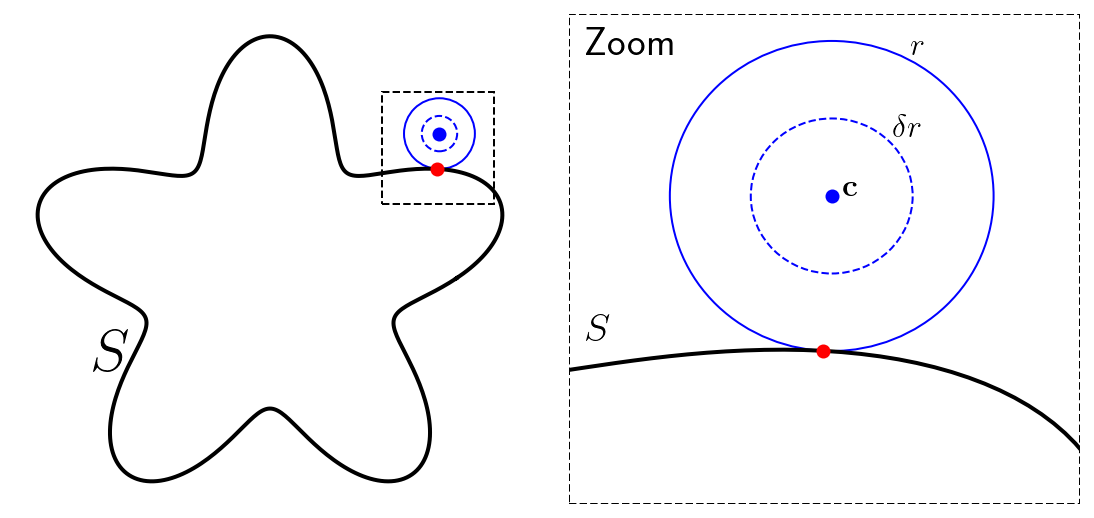

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
theta = np.linspace(0, 2 * np.pi, 500)
xsS = np.cos(theta) * (1.0 + 0.3 * np.sin(theta * 5))
ysS = np.sin(theta) * (1.0 + 0.3 * np.sin(theta * 5))

t = theta
dxdt = np.sin(t) * (-0.3 * np.sin(5 * t) - 1) + 1.5 * np.cos(t) * np.cos(5 * t)
dydt = np.cos(t) + 1.5 * np.cos(5 * t) * np.sin(t) + 0.3 * np.cos(t) * np.sin(5 * t)
ddt_norm = np.sqrt(dxdt ** 2 + dydt ** 2)
dxdt /= ddt_norm
dydt /= ddt_norm
nx = dydt
ny = -dxdt
jacobian = 2 * np.pi * ddt_norm

plt.plot(xsS, ysS, "k-")
plt.text(-0.95, -0.5, "$S$", fontsize=30)
plt.gca().add_patch(
    patches.Rectangle(
        (0.6, 0.4), 0.6, 0.6, edgecolor="k", linestyle="--", facecolor="none"
    )
)
plt.axis("off")

theta_C_idx = 46
theta_C = theta[theta_C_idx]
xsS_C = xsS[theta_C_idx]
ysS_C = ysS[theta_C_idx]

r = 0.19
Cx = xsS_C + r * nx[theta_C_idx]
Cy = ysS_C + r * ny[theta_C_idx]
plt.plot([xsS_C], [ysS_C], "ro")
plt.plot([Cx], [Cy], "bo")
plt.gca().add_patch(plt.Circle((Cx, Cy), r, fill=False, color="b"))
plt.gca().add_patch(
    plt.Circle((Cx, Cy), r * 0.5, fill=False, color="b", linestyle="--")
)

plt.subplot(1, 2, 2)
plt.plot(xsS, ysS, "k-")
plt.gca().add_patch(
    patches.Rectangle(
        (0.6, 0.4), 0.6, 0.6, edgecolor="k", linestyle="--", facecolor="none"
    )
)
plt.text(0.62, 0.95, "Zoom", fontsize=20)
plt.text(0.62, 0.6, "$S$", fontsize=20)
plt.plot([xsS_C], [ysS_C], "ro")
plt.plot([Cx], [Cy], "bo")
plt.gca().add_patch(plt.Circle((Cx, Cy), r, fill=False, color="b"))
plt.gca().add_patch(
    plt.Circle((Cx, Cy), r * 0.5, fill=False, color="b", linestyle="--")
)
plt.text(1.0, 0.95, "$r$", fontsize=16)
plt.text(0.98, 0.85, "$\delta r$", fontsize=16)
plt.text(Cx + 0.013, Cy, "$\mathbf{c}$", fontsize=16)
plt.xlim([0.6, 1.2])
plt.ylim([0.4, 1.0])
plt.axis("off")

plt.tight_layout()
plt.show()
# circle = plt.Circle((0,0), node.radius, fill=False, color='b' if node.is_leaf else 'k')
# plt.gca().add_patch(circle)

### Summary

So, what's the full algorithm look like?

1. Choose an expansion center a distance of $r$ away from the surface.
2. Discretize the integrals for the expansion coefficients and identify the points where we will need to evaluate $u(\mathbf{c} + \delta r(cos \theta, sin \theta))$.
3. Evaluate $u(\mathbf{p})$ for those points by directly evaluating $\int K(\mathbf{p}, \mathbf{q}) \phi(\mathbf{q}) d\mathbf{q}$ using a simple quadrature rule (e.g. Gaussian quadrature). Because we choose, $\delta = 1/2$, the closest we will have to evaluate $u(\mathbf{p})$ is $r/2$.
4. Integrate/sum to compute $\alpha_l$. 
5. Now that we have the coefficients $\alpha_l$, to evaluate $u(\mathbf{p})$ at any point arbitrarily close to the surface, simply evaluate the complex power series and take the real part. 

Some comments about QBX:
* Because the evaluation of the series is independent of the computation of the coefficients, we can compute **many near-field values for the price of one**.
* The method actually works just as well for computing a $u(\mathbf{p})$ directly on the boundary. To be precise, we can compute a limit to the boundary like $\lim_{\mathbf{p} \to S^+}u(\mathbf{p})$. Thus, QBX can actually **replace the singular quadrature required in many boundary integral methods**.
* The method works best when there are no singularities in $u(\mathbf{p})$. The most common violation of this is a sharp corner in $S$. When there are corners, QBX will still work, but the expansion center $c$ will need to be closer to the surface and, as a result, a high number of quadrature points will be needed in the vicinity of the corner. 
* There are three relevant parameters which all control the accuracy. The distance to offset from the surface, $r$. The order of the expansion, $p$. And the order of quadrature method used to compute the coefficients of the expansion, $n_q$. They interact in somewhat complex ways. 
* By increasing $r$, the expansion is formed further from the surface and (holding $n_q$ constant) the expansion coefficients will be computed more accurately, but (holding $p$ constant) the accuracy of the expansion near the surface will decrease because the distance from the evaluation point to the expansion center is larger. 
* Increasing $p$ will improve the accuracy of the expansion up to a point, but eventually the higher order terms in the expansion will become corrupted by the error introduced by the numerical integration. So, in order to increase $p$, $n_q$ must also increase.

## Implementing QBX

### The double layer potential on a circle.

Great, let's put together a simple implementation for the Laplace double layer potential! The double layer potential is one of the fundamental objects of potential theory and, physically, is the integral that computes the electric or magnetic potential due to a dipolar surface. Or, the integral that computes the displacement due to an earthquake under the assumption of antiplane strain. 

```{margin}
How easily do these double layer potential calculations extend to 2D plane-strain elasticity? Super easily. In fact, basically nothing needs to change except that we do everything four times, once for each component of the 2x2 tensor form of the equations! Extension to 3D elasticity is even more involved from a software and computational standpoint, but also does not require major algorithmic changes.
```

First, we'll set up a few useful functions. We'll create a source surface/mesh out of circle evaluated the nodes of a trapezoidal quadrature rule.

In [3]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

In [4]:
import_and_display_fnc('common', 'trapezoidal_rule')
import_and_display_fnc('common', 'Surface')
import_and_display_fnc('common', 'circle')

def trapezoidal_rule(n):
    """
    The n-point trapezoidal rule on [-1, 1].
    Returns tuple of (points, weights)
    """
    return np.linspace(-1.0, 1.0, n + 1)[:-1], np.full(n, 2.0 / n)

@dataclass()
class Surface:
    """
    A surface consists of:

    `quad_pts` and `quad_wts`: a set of quadrature nodes and weights specifying
        where in [-1, 1] parameter space each interpolation point lies.

    `pts`: a set of interpolation points that define the mesh,

    `normals`: the normal vectors to the surface at the points,

    `jacobians`: the determinant of the curve's jacobian at the points

    """

    quad_pts: np.ndarray
    quad_wts: np.ndarray
    pts: np.ndarray
    normals: np.ndarray
    jacobians: np.ndarray

    @property
    def n_pts(
        self,
    ):
        return self.pts.shape[0]

def circle(n):
    """
    Construct a circular surface with the normal vectors pointing outwards.

    The natural choice for quadrature on a circle is a trapezoidal rule due
    to its exponential convergence on a periodic domain.
    """

    quad_pts, quad_wts = trapezoidal_rule(n)

    # Convert from [-1,1] to [0,2*pi]
    theta = np.pi * (quad_pts + 1)
    pts = np.hstack([np.cos(theta)[:, None], np.sin(theta)[:, None]])
    normals = pts
    jacobians = np.full(pts.shape[0], np.pi)
    return Surface(quad_pts, quad_wts, pts, normals, jacobians)

```{margin}
Functions and classes with "[Library]" in small print above are being imported from the library. I will include the implementation in the text the first time a function is used. In later notebooks, we will just import the function directly. To see the full library, take a look at `common.py`.
```

The double layer potential takes the form of a standard boundary integral operator, where the specific form of $K(\mathbf{p}, \mathbf{q})$ can be found in the `double_layer_matrix` code below.

\begin{equation}
u(x) = \int_{S} K(\mathbf{p}, \mathbf{q}) \phi(\mathbf{q}) d\mathbf{q}
\end{equation}

Discretizing the integral for many observation points indexed by $i$ and for many source points indexed by $j$, the result:

\begin{equation}
u_i = \sum_j K(\mathbf{p}_i, \mathbf{q}_j) \phi(\mathbf{q}_j)
\end{equation}

can be written in matrix form:

\begin{equation}
\textbf{u} = \textbf{A} \textbf{b}
\end{equation}

where the matrix of interest is $A_{ij} = K(\mathbf{p}_i, \mathbf{q}_j)$. This function computes that matrix for $K(\mathbf{p}, \mathbf{q})$ is known as the dipole kernel of the Laplace equation or the "slip to displacement" kernel for antiplane elasticity! The function below builds this matrix!

In [5]:
import_and_display_fnc('common', 'double_layer_matrix')

def double_layer_matrix(source, obs_pts):
    """
    Compute the entries of the matrix that forms the double layer potential.
    """
    dx = obs_pts[:, 0, None] - source.pts[None, :, 0]
    dy = obs_pts[:, 1, None] - source.pts[None, :, 1]
    r2 = dx ** 2 + dy ** 2

    # The double layer potential
    integrand = (
        -1.0
        / (2 * np.pi * r2)
        * (dx * source.normals[None, :, 0] + dy * source.normals[None, :, 1])
    )

    return (integrand * source.jacobians * source.quad_wts[None, :])[:, None, :]

So, let's plot up what $u(\mathbf{p})$ looks like. For the rest of this section, we'll use the simple $\phi(\mathbf{q}) = q_y$ as the source function and use a circle as the surface $S$. In the next section, we'll explore some more interesting geometries and functions. Let's start by using a fairly low quadrature order, just 50 points on the whole circle.

In [6]:
import_and_display_fnc('common', 'pts_grid')

def pts_grid(xs, ys):
    """
    Takes two 1D arrays specifying X and Y values and returns a
    (xs.size * ys.size, 2) array specifying the grid of points in the Cartesian
    product of `xs` and `ys`.
    """
    return np.hstack([v.ravel()[:, None] for v in np.meshgrid(xs, ys)])

In [7]:
nobs = 100
xs = np.linspace(-2, 2, nobs)
ys = np.linspace(-2, 2, nobs)
obs_pts = pts_grid(xs, ys)

surface_low = circle(50)

And this is the meat of the $\textbf{u} = \textbf{A}\textbf{b}$ calculation:

In [8]:
A = double_layer_matrix(surface_low, obs_pts)
phi = surface_low.pts[:, 1]  # phi = y_2
u = A.dot(phi)  # u = Ab
u = u.reshape((nobs, nobs))

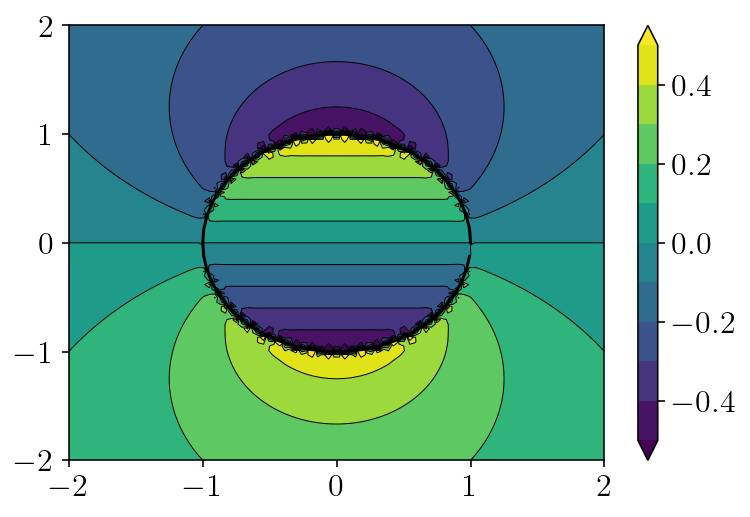

In [9]:
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
cntf = plt.contourf(xs, ys, u, levels=np.linspace(-0.5, 0.5, 11), extend="both")
plt.contour(
    xs,
    ys,
    u,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.5, 0.5, 11),
    extend="both",
)
plt.colorbar(cntf)
plt.show()

Pretty picture. But, you can immediately see the uglyness near the boundary! This is what we'll solve with QBX. Let's actually quantify that error. We'll compare our 50 point integration against a 2000 point integration.

In [10]:
zoomnobs = 200
zoomx = [-1.6, -0.4]
zoomy = [-0.6, 0.6]
zoomxs = np.linspace(*zoomx, zoomnobs)
zoomys = np.linspace(*zoomy, zoomnobs)
zoomobs_pts = pts_grid(zoomxs, zoomys)

zoomu_low = (
    double_layer_matrix(surface_low, zoomobs_pts)
    .dot(surface_low.pts[:,1])
    .reshape((zoomnobs, zoomnobs))
)

surface_high = circle(2000)
zoomu_high = (
    double_layer_matrix(surface_high, zoomobs_pts)
    .dot(surface_high.pts[:,1])
    .reshape((zoomnobs, zoomnobs))
)

<ipython-input-11-a549c8f2310c>:40: RuntimeWarning: divide by zero encountered in log10
  logerror = np.log10(np.abs(zoomu_low - zoomu_high))


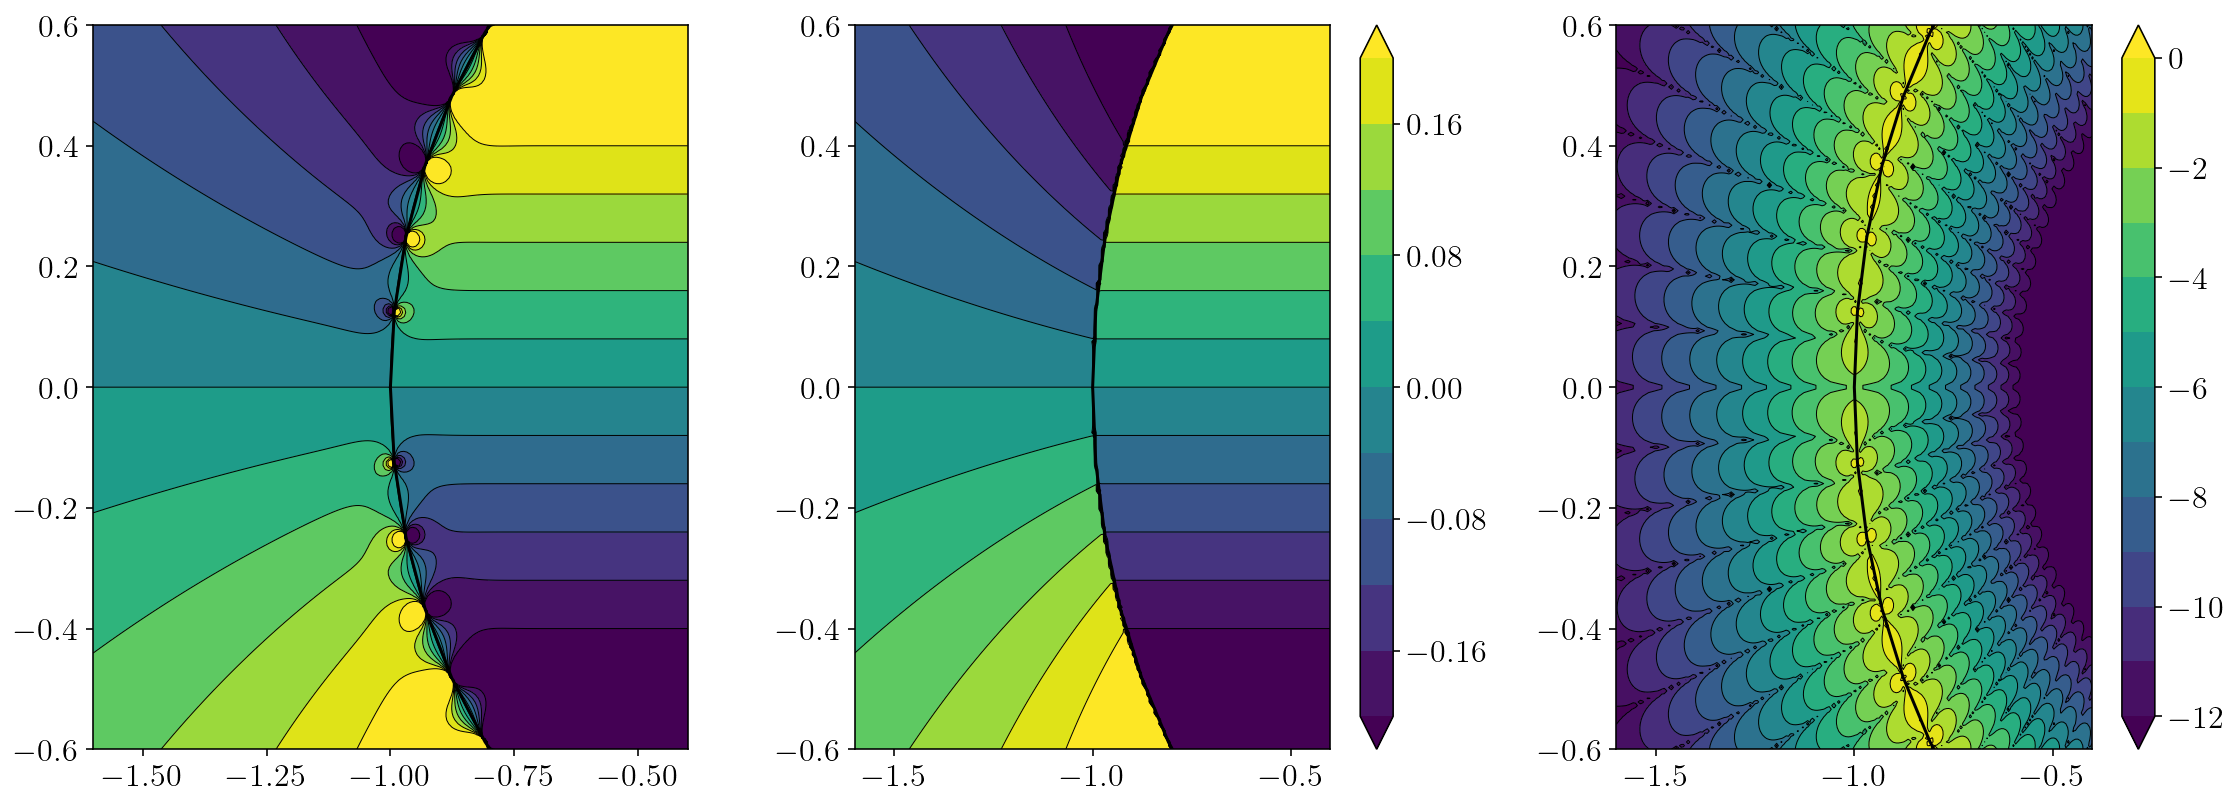

In [11]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_low, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_low,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 2)
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_high, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_high,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(zoomu_low - zoomu_high))
logerror[np.isinf(logerror)] = -12.0
cntf = plt.contourf(
    zoomxs, zoomys, logerror, levels=np.linspace(-12, 0, 13), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-12, 0, 13),
    extend="both",
)
plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()

We're zoomed in on the left edge of the circle here which shows the little dipoles from the low order quadrature on the left. In the middle, the super high order quadrature cleans up the picture (but, note that if you zoomed in by a factor of 10x, you'd see the dipoles again even with the 2000 point quadrature). The right hand figure shows the $\log_{10}$ error in the low order integrals. The error very close to the surface is more-or-less 100%.

### Accurate near-field evaluation

Let's try again with the low-order quadrature rule but this time using QBX! We're going to use a tenth order expansion centered at $(-1.5, 0.2)$.

In [12]:
qbx_p = 10
qbx_center_x = -1.5
qbx_center_y = 0.2

So, we now need to compute the circular integrals for the coefficients. A rule of thumb is to use a trapezoidal rule with $2p$ points.

In [13]:
trap_x, trap_weights = trapezoidal_rule(2 * qbx_p)

# transform the quadrature rule from [-1, 1] to [0, 2*pi]
trap_theta = np.pi * (trap_x + 1)
# multiply the quadrature weights by the jacobian of the transformation
trap_weights *= np.pi

Our expansion center is approximately a distance of 0.5 from the boundary, so our coefficient integrals are computed a distance of 0.25 from the expansion center (remember $\delta = 1/2$).

In [14]:
qbx_delta_r = 0.25
# (qbx_x, qbx_y) defines the points used for computing the circular coefficient integrals centered at the expansion center.
qbx_x = qbx_delta_r * np.cos(trap_theta) + qbx_center_x
qbx_y = qbx_delta_r * np.sin(trap_theta) + qbx_center_y

Now, we need the value of $u(x)$ at the points `(qbx_x, qbx_y)`.

In [15]:
qbx_xy = np.hstack((qbx_x[:,None], qbx_y[:,None]))
qbx_u = double_layer_matrix(surface_low, qbx_xy).dot(phi)[:,0]

And here we implement the coefficient integrals. This looks ugly, but it's a direct implementation of the discretized coefficient integrals where $\omega_i$ are the quadrature weights `trap_ws`

$$\alpha_l = \frac{1}{\pi (\delta r)^l}\sum_{i=0}^{2p} \omega_i u(\mathbf{c} + \delta r(cos \theta_i, sin \theta_i)) e^{-il\theta_i} $$

In [16]:
alpha = []
for L in range(qbx_p):
    C = 1.0 / (np.pi * (qbx_delta_r ** L))
    if L == 0:
        C /= 2.0
    alpha.append(C * np.sum(trap_weights * qbx_u * np.exp(-1j * L * trap_theta)))

We convert the expansion center and the observation points to be complex.

In [17]:
zoom_complex = (zoomobs_pts[:,0] + zoomobs_pts[:,1] * 1j).reshape((zoomnobs, zoomnobs))
qbx_center = qbx_center_x + qbx_center_y * 1j

And finally, evaluate the expansion in complex space:

In [18]:
zoomu_qbx = np.zeros_like(zoomu_low)
for L in range(qbx_p):
    zoomu_qbx += np.real(alpha[L] * ((zoom_complex - qbx_center) ** L))

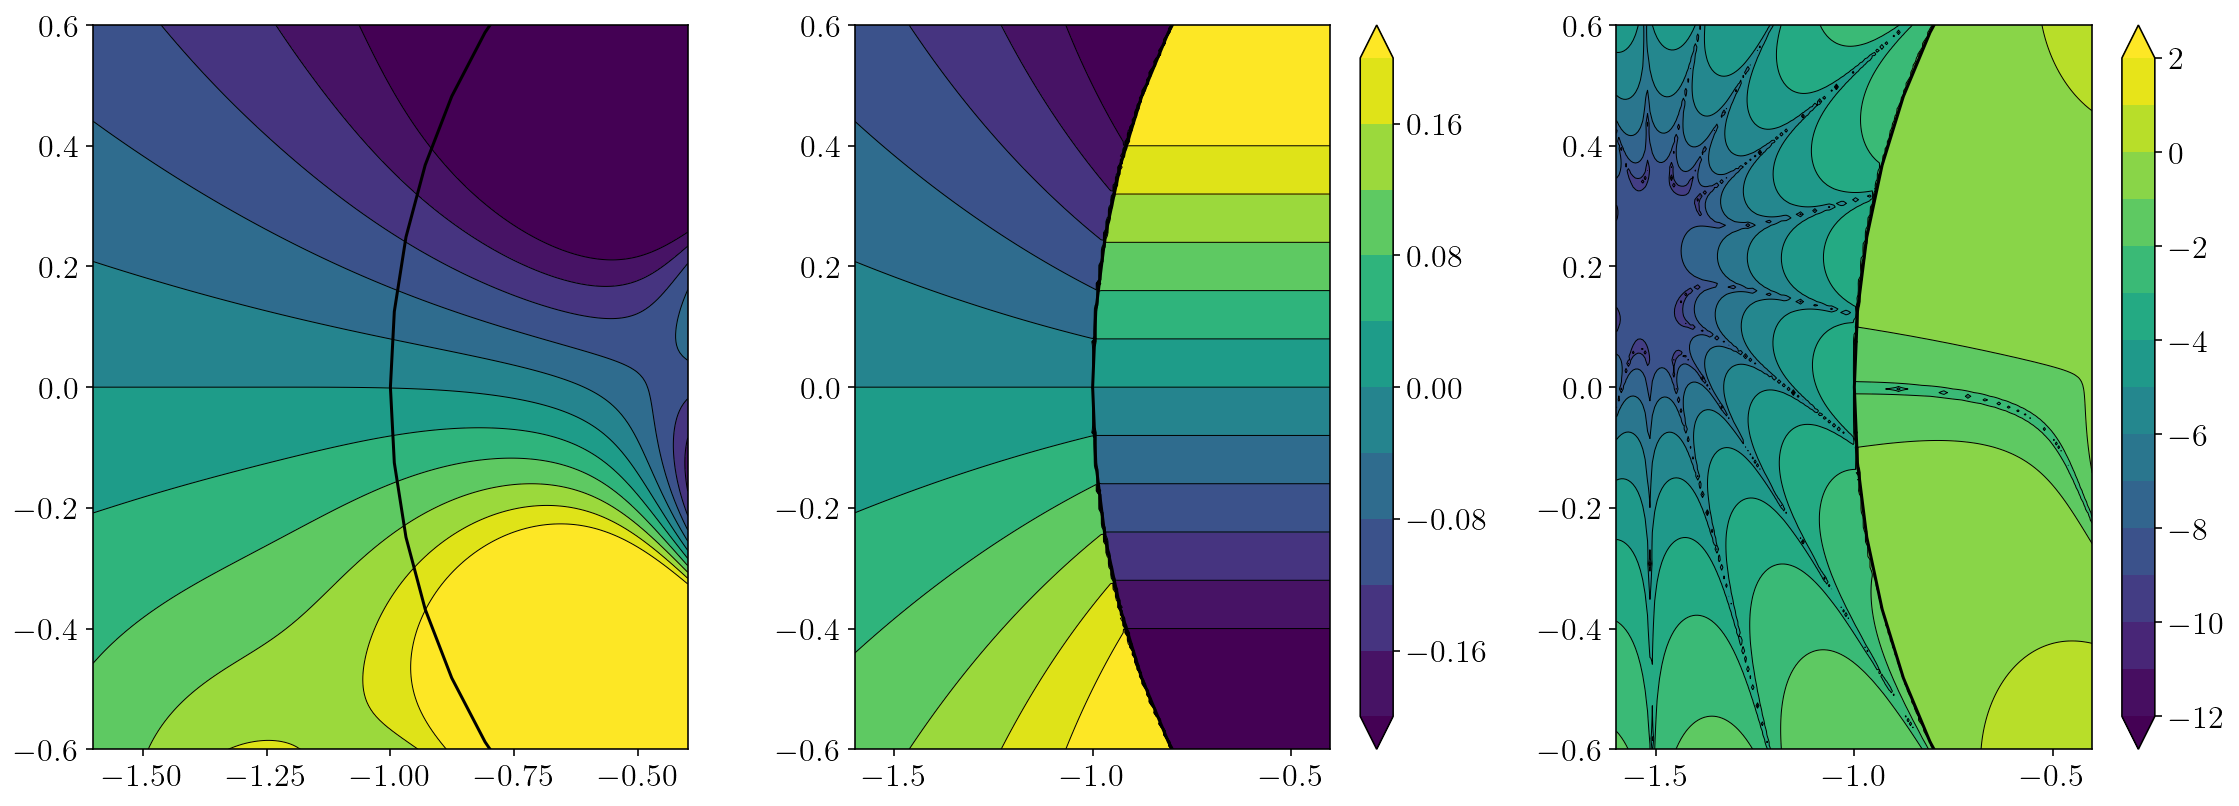

In [19]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_qbx, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_qbx,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 2)
cntf = plt.contourf(
    zoomxs, zoomys, zoomu_high, levels=np.linspace(-0.2, 0.2, 11), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    zoomu_high,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-0.2, 0.2, 11),
    extend="both",
)
plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(zoomu_qbx - zoomu_high))
logerror[np.isinf(logerror)] = -12.0
cntf = plt.contourf(
    zoomxs, zoomys, logerror, levels=np.linspace(-12, 2, 15), extend="both"
)
plt.contour(
    zoomxs,
    zoomys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=np.linspace(-12, 2, 15),
    extend="both",
)
plt.colorbar(cntf)
plt.plot(surface_low.pts[:,0], surface_low.pts[:,1], "k-", linewidth=1.5)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.tight_layout()
plt.show()

The left panel here shows $u(x)$ from the QBX evaluation, the middle panel shows $u(x)$ from the 2000 point quadrature and the right panel shows the $\log_{10}$ error in the QBX evaluation. Take-aways:
* The error near the portion of the surface closest to the expansion center is now quite good. We're succesfully doing an accurate near-field evaluation!
* Points far away from the expansion center are less accurate.
* The QBX expansion is entirely wrong interior to the circle on the other side of the surface. This is entirely expected since there is a jump in $u(x)$ across the surface and a step function like that would be impossible to approximate with a power series.

## General-purpose QBX implementation

While what we did so far is a cool demonstration, it's not a practical implementation. Ultimately, we need to be able to provide a big list of observation points and expect the code to choose whether to compute the integral directly or, if a point is near the surface, use QBX. And, we need to assign points to which expansion they are going to use.

It might make sense to skip to the end of this section and take a look at the figure generated to understand what the end goal is.

First, I'll share the the implementation of a couple functions that generalize and vectorize the code from above. The docstring for `QBXExpansions` will hopefully provide a high-level overview of the structure of the code, separating the computation into setup, expansion and evaluation. Depending on how detailed of an understanding you want, please feel free to either read the implementation in detail or just stick to reading the docstrings. 

In [20]:
import_and_display_fnc('common', 'QBXExpansions')
import_and_display_fnc('common', 'qbx_setup')
import_and_display_fnc('common', 'qbx_expand_matrix')
import_and_display_fnc('common', 'qbx_eval_matrix')

@dataclass()
class QBXExpansions:
    """
    There are three main operations involving QBX expansions:
    1. Setup via `qbx_setup`: This identifies the proper locations for the expansions.
    2. Expansions via `qbx_expand_matrix`: Given a kernel and source surface,
       construct a matrix that computes the coefficients of the power series from
       the source density field.
    3. Evaluation via `qbx_eval_matrix` and `qbx_interior_eval_matrix`: Constructing
       a matrix that computes integral values at observation points given an already
       computed expansion.

    This might make more sense in reference to a simple Taylor series:
    f(x_i) = C_0 + C_1(x_i - x0) + C_2(x_i - x0)^2 + ...

    1. "Setup", is choosing x0.
    2. "Expansion" is calculating the coefficients C_j
    3. "Evaluation" is calculating f(x_i)

    A QBX power series expansion is defined in reference to an underlying
    source surface.

    `pts`: The expansion centers that are offset from the source surface.

    `r`: The distance from the source surface to the expansion center.

    `p`: The whole set of expansions has a constant `p` which is the
        number of terms in the expansion (in principle, there is no reason that the
        order could not vary from expansion to expansion, but keeping it constant
        simplifies the implementation.)
    """

    pts: np.ndarray
    r: np.ndarray
    p: int

    @property
    def N(self):
        return self.pts.shape[0]

def qbx_setup(source, mult=5.0, direction=0, p=5):
    """
    Set up the expansion centers for a source surface. The centers will be
    offset by a distance proportional to the local jacobian of the surface.

    By default, two sets of expansion centers will be created: one set on each
    side of the source surface.  The expansion center will be offset from the
    surface in the direction of `surface.normals`.

    `source`: The source surface over which integrals are computed.

    `mult`: A multiplier for the offset.

    `direction`: The direction to offset the expansion centers. By default this
    is zero and as a result, expansion centers will be created on both sides of
    the source surface.

    `p`: The order of QBX expansion.
    """
    relative_spacing = np.mean(source.quad_wts)
    quad_pt_spacing = source.jacobians * np.full(source.n_pts, relative_spacing)
    r = mult * quad_pt_spacing

    if direction == 0:
        centers1 = source.pts + r[:, None] * source.normals
        centers2 = source.pts - r[:, None] * source.normals
        centers = np.concatenate((centers1, centers2))
        r = np.concatenate((r, r))
    else:
        centers = source.pts + direction * r[:, None] * source.normals

    return QBXExpansions(centers, r, p)

def qbx_expand_matrix(kernel, source, expansions):
    """
    Given a kernel and source surface, construct a matrix that computes the
    coefficients of the QBX power series from the source density field.

    `kernel`: The kernel function in the integrals.

    `source`: The source surface over which integrals are computed.

    `expansions`: The location of QBX expansions.
    """

    # We'll compute for many expansion centers at once.  There will be one
    # expansion center for each point on the input source surface.  We'll also
    # compute the matrix form so that we can apply it multiply times for
    # different source functions.

    # Construct the quadrature points on the circles surrounding each expansion.
    qbx_nq = 2 * expansions.p + 1
    qbx_qx, qbx_qw = trapezoidal_rule(qbx_nq)
    qbx_qw *= np.pi
    qbx_theta = np.pi * (qbx_qx + 1)

    # The evaluation radius for each center. Ideally the radius is
    # small enough that all the points on the boundary of the expansion circle
    # are still far enough from the source surface.
    qbx_eval_r = expansions.r * 0.5

    # The points where we evaluate source integrals! This will have a shape:
    # (expansions.N, qbx_nq, 2)
    qbx_eval_pts = np.tile(
        expansions.pts.copy()[:, None, :], (1, qbx_theta.shape[0], 1)
    )
    qbx_eval_pts[:, :, 0] += qbx_eval_r[:, None] * np.cos(qbx_theta)[None, :]
    qbx_eval_pts[:, :, 1] += qbx_eval_r[:, None] * np.sin(qbx_theta)[None, :]

    # Evaluate the integrals!
    Keval = kernel(source, qbx_eval_pts.reshape((-1, 2)))
    kernel_ndim = Keval.shape[1]
    qbx_u_matrix = Keval.reshape((expansions.N, qbx_nq, kernel_ndim, source.n_pts))

    # Compute the expansion coefficients in matrix form.
    alpha = np.empty(
        (expansions.pts.shape[0], kernel_ndim, expansions.p, source.n_pts),
        dtype=np.complex128,
    )
    for L in range(expansions.p):
        C = 1.0 / (np.pi * (qbx_eval_r ** L))
        if L == 0:
            C /= 2.0
        oscillatory = qbx_qw[None, :, None] * np.exp(-1j * L * qbx_theta)[None, :, None]
        alpha[:, :, L, :] = C[:, None, None] * np.sum(
            qbx_u_matrix * oscillatory[:, :, None], axis=1
        )
    return alpha

def qbx_eval_matrix(obs_pts_per_expansion, expansions):
    """
    Construct a matrix evaluating the QBX integrals from `expansions` to `obs_pts`.

    `obs_pts_per_expansion`: an array of observation points for each expansion. Expected to
    have a shape like (M, expansions.N).

    `expansions`: The QBX expansions.
    """

    obs_complex = obs_pts_per_expansion[:, :, 0] + obs_pts_per_expansion[:, :, 1] * 1j
    qbx_center = expansions.pts[:, 0] + expansions.pts[:, 1] * 1j
    sep = obs_complex - qbx_center[None, :]
    out = np.empty(
        (obs_pts_per_expansion.shape[0], obs_pts_per_expansion.shape[1], expansions.p),
        dtype=np.complex,
    )
    for L in range(expansions.p):
        out[:, :, L] = sep ** L
    return out


Next up is the fun part. This function identifies which expansion center to use for which observation points by finding which expansion is closest. And then we construct a QBX evaluation matrix to perform the evaluation. 

In [21]:
import_and_display_fnc('common', 'interior_matrix')
import_and_display_fnc('common', 'qbx_interior_eval_matrix')

def interior_matrix(kernel, source, obs_pts, expansions):
    expand = qbx_expand_matrix(kernel, source, expansions)
    interior = qbx_interior_eval_matrix(kernel, source, obs_pts, expansions)

    out_for_qbx_points = np.sum(
        np.real(
            interior.matrix[:, :, None, :, None]
            * expand[interior.centers_used][None, :, :]
        ),
        axis=3,
    )

    entries_used = interior.obs_pt_idxs >= 0


    out = np.empty((obs_pts.shape[0], expand.shape[1], source.n_pts))

    # Which observation points used QBX? Use the QBX results for those!
    obs_pt_qbx = interior.obs_pt_idxs[entries_used]
    out[obs_pt_qbx] = out_for_qbx_points[entries_used]

    # Which observations did not need QBX? Use a naive integrator for those by
    # calling the kernel directly!
    obs_pt_not_qbx = np.setdiff1d(np.arange(obs_pts.shape[0]), obs_pt_qbx)
    out[obs_pt_not_qbx] = kernel(source, obs_pts[obs_pt_not_qbx])

    return out

def qbx_interior_eval_matrix(
    kernel,
    source,
    obs_pts,
    expansions,
):
    """
    This function identifies which expansion center to use for which
    observation points by finding which expansion is closest. And then we
    construct a QBX evaluation matrix to perform the evaluation.
    """

    # Build a KDTree for doing nearest neighbor searches amongst the QBX centers
    centers_tree = scipy.spatial.cKDTree(expansions.pts)

    # And also for doing nearest neighbor searches on the source surface.
    source_tree = scipy.spatial.cKDTree(source.pts)

    # Identify the distance to the closest expansion, which expansion that is,
    # and the distance to the source surface.
    dist_to_expansion, closest_expansion = centers_tree.query(obs_pts)
    dist_to_source, _ = source_tree.query(obs_pts)

    # Only use QBX if point is close enough to the surface and the point is
    # close enough to its respective QBX expansion center To measure "close
    # enough", we use r, which is the distance from the surface.
    use_qbx = (dist_to_expansion < expansions.r[closest_expansion]) & (
        dist_to_source < expansions.r[closest_expansion]
    )

    # And we identify which expansion centers are ever used, and how many times.
    centers_used, center_counts = np.unique(
        closest_expansion[use_qbx], return_counts=True
    )

    # This part is slightly complex. The vectorization in qbx_eval_matrix means
    # that for each QBX center, we need to compute the same number of
    # observation points. So, we find the maximum number of observation points
    # for any expansion center. eval_pts is going to be the list of points
    # for each expansion center obs_pt_idxs is a mapping back to which indices
    # those points correspond to in the original obsx and obsy input arrays.
    # Because some expansion centers won't use the full n_max_per_qbx_center
    # observation points, obs_pt_idxs equals -1 by default. This will be used
    # later to identify which entries are valid and which are just
    # "vectorization junk".
    n_max_per_center = np.max(center_counts)
    eval_pts = np.zeros((n_max_per_center, centers_used.shape[0], 2))
    obs_pt_idxs = np.full((n_max_per_center, centers_used.shape[0]), -1, dtype=np.int)

    for (i, c) in enumerate(centers_used):
        # So, for each QBX center, we find the observation points that use it.
        idxs = np.where((closest_expansion == c) & use_qbx)[0]
        obs_pt_idxs[: idxs.shape[0], i] = idxs
        eval_pts[: idxs.shape[0], i] = obs_pts[obs_pt_idxs[: idxs.shape[0], i], :]

    # This is the matrix that maps from QBX coeffs to observation point
    Q = qbx_eval_matrix(
        eval_pts,
        QBXExpansions(
            expansions.pts[centers_used],
            expansions.r[centers_used],
            expansions.p,
        ),
    )
    return QBXInteriorEval(Q, centers_used, obs_pt_idxs)

Whew. That was a challenge. If the code isn't making complete sense, I'd encourage you to try downloading the Jupyter notebook and stepping through line by line looking at the shapes of the various arrays. Vectorized code can be challenging.

The part below should look familiar. We're calculating a low and high order baseline solution for calculating errors and comparing QBX against the naive approach.

In [22]:
n = 200
surface = circle(n)

nobs = 400
zoomx = [0.75, 1.25]
zoomy = [0.15, 0.65]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)

bie_eval = (
    double_layer_matrix(surface, obs_pts)
    .dot(surface.pts[:,1])
    .reshape((nobs, nobs))
)

surface_high = circle(2000)
bie_eval_high = (
    double_layer_matrix(surface_high, obs_pts)
    .dot(surface_high.pts[:,1])
    .reshape((nobs, nobs))
)

Now, we get into the meat of it. Using an 8th order QBX expansion, we'll create expansions away from the surface for each source point. `qbx_center_x` and `qbx_center_y` are the coordinates of those expansion centers and `qbx_r` is both the maximum radius at which the expansion is valid and the distance from the surface to the expansion center. `Qexpand` will be a matrix that maps from the source density to the expansion coefficients. As a result, `qbx_coeffs` are the coefficients resulting from the density `surface[1]` (just the y coordinate on the surface). 

Note that everything in this cell is independent of the observation points. We can re-use these expansion coefficients for many different sets of observation points.

And then compute $u(x)$ for every observation point. As we saw above, `qbx_interior_eval` will decide whether to use QBX or which expansion to use depending on where an observation point is located.

In [23]:
expansions = qbx_setup(surface, mult=5.0, direction=1.0, p=8)

bie_eval_full_qbx = interior_matrix(
    double_layer_matrix,
    surface,
    obs_pts,
    expansions
)[:,0,:].dot(surface.pts[:,1]).reshape((nobs, nobs))

We'll also create a second solution where we use just a single QBX center with index 14. This is nice just for demonstrating the the effect of a single expansion!

In [24]:
bie_eval_qbx14 = interior_matrix(
    double_layer_matrix,
    surface,
    obs_pts,
    QBXExpansions(
        expansions.pts[14:15],
        expansions.r[14:15],
        expansions.p
    )
)[:,0,:].dot(surface.pts[:,1]).reshape((nobs, nobs))

In [25]:
import warnings

warnings.filterwarnings("ignore")

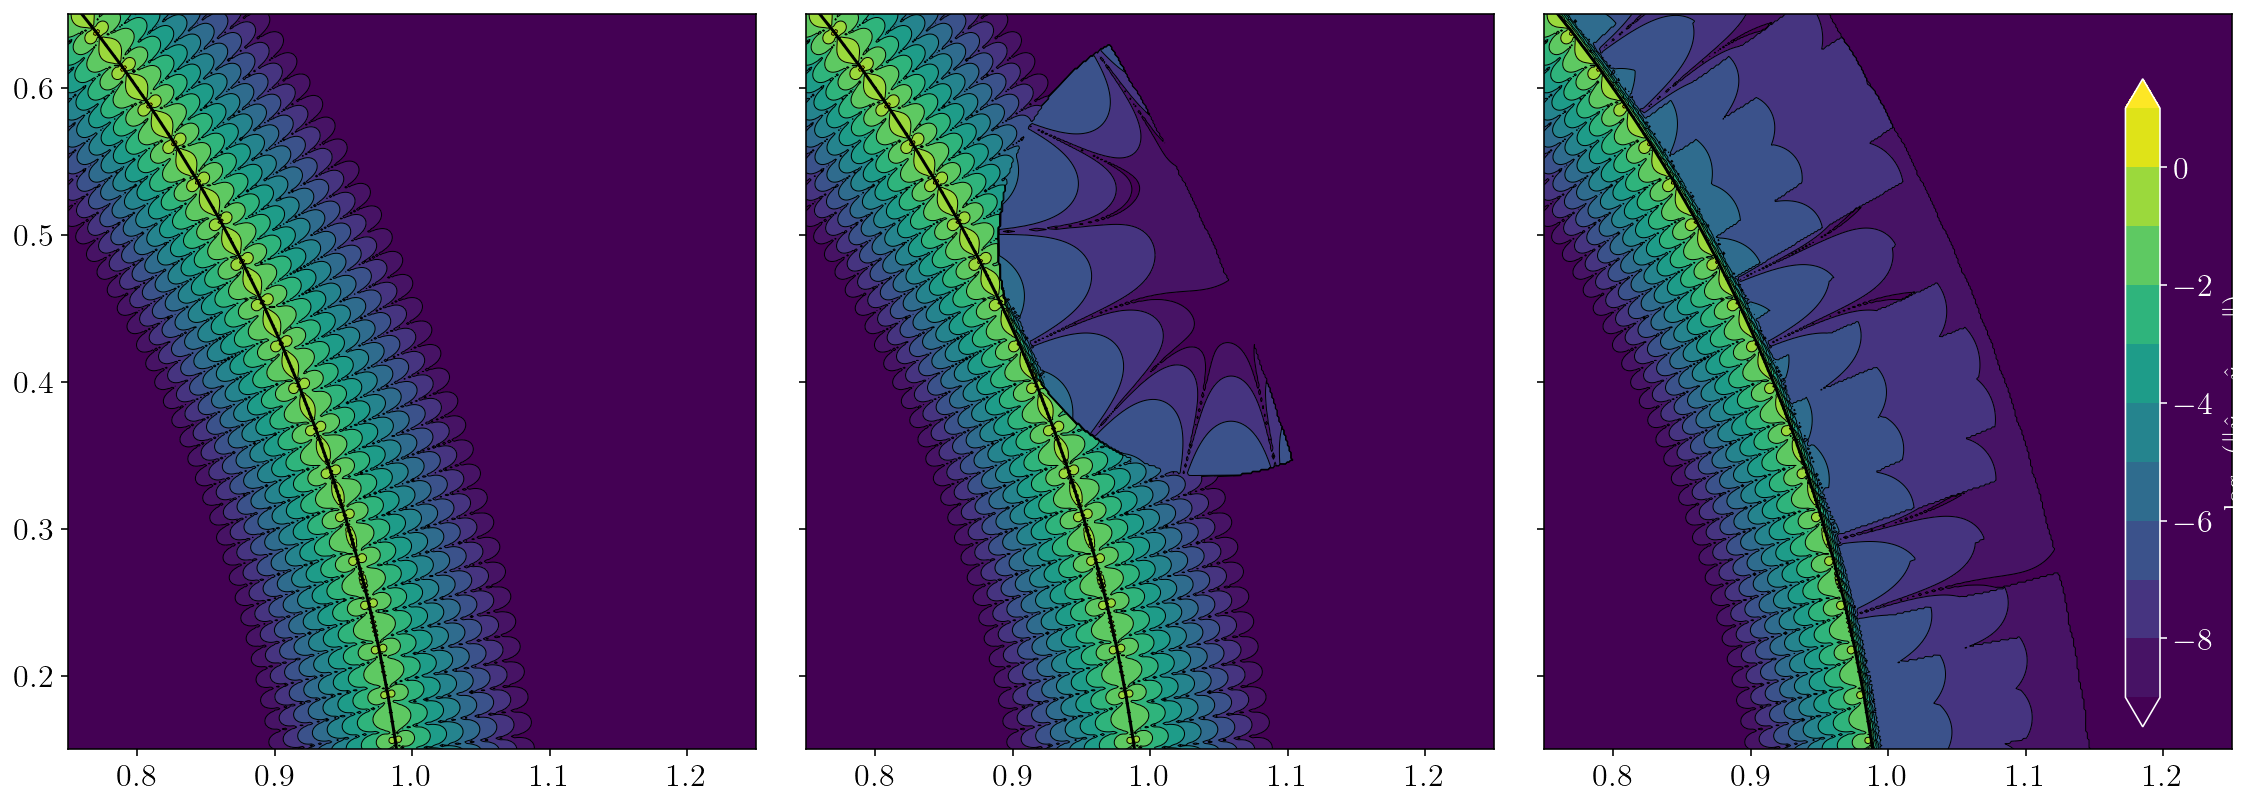

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
plt.subplot(1, 3, 1)
logerror = np.log10(np.abs(bie_eval_high - bie_eval))
logerror[np.isinf(logerror)] = -17.0
plt.plot(surface.pts[:,0], surface.pts[:,1], "k-", linewidth=1.5)
error_levels = np.linspace(-9, 1, 11)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(
    xs,
    ys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1, 3, 2)
logerror = np.log10(np.abs(bie_eval_high - bie_eval_qbx14))
logerror[np.isinf(logerror)] = -17.0
plt.plot(surface.pts[:,0], surface.pts[:,1], "k-", linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(
    xs,
    ys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
plt.gca().axes.yaxis.set_ticklabels([])

plt.subplot(1, 3, 3)
logerror = np.log10(np.abs(bie_eval_high - bie_eval_full_qbx))
logerror[np.isinf(logerror)] = -17.0
plt.plot(surface.pts[:,0], surface.pts[:,1], "k-", linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(
    xs,
    ys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
plt.gca().axes.yaxis.set_ticklabels([])

# fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.935, 0.125, 0.015, 0.75])
cbar_ax.patch.set_alpha(0.0)
cb = fig.colorbar(cntf, cax=cbar_ax)

cb.set_label(
    "$\log_{10}(\|\hat{u} - \hat{u}_{\\textrm{QBX}}\|)$", color="w", fontsize=14
)
cb.ax.yaxis.set_tick_params(color="w")
cb.outline.set_edgecolor("w")
cbytick_obj = plt.getp(cb.ax.axes, "yticklabels")
plt.setp(cbytick_obj, color="w")

plt.tight_layout()
plt.show()

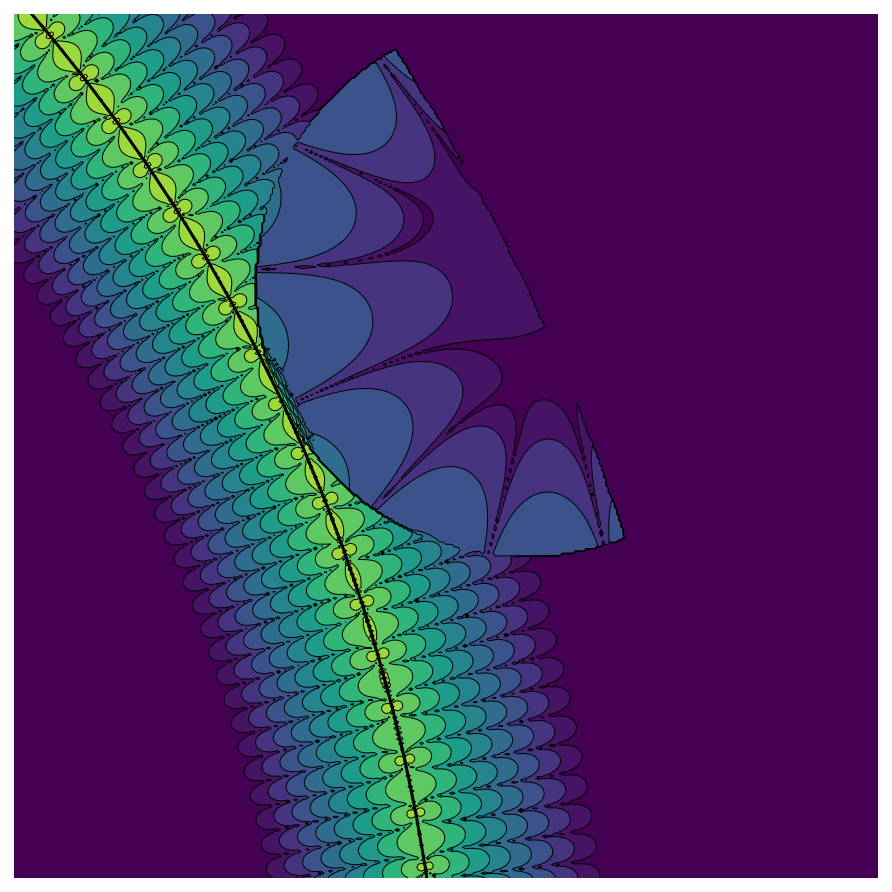

In [27]:
# REMOVED_CELL_ALERT
logerror = np.log10(np.abs(bie_eval_high - bie_eval_qbx14))
logerror[np.isinf(logerror)] = -17.0
start_idx = 1
end_idx = 50
plt.figure(figsize=(6, 6))
plt.plot(surface.pts[1:50,0], surface.pts[1:50,1], "k-", linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(
    xs,
    ys,
    logerror,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=error_levels,
    extend="both",
)
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
ax.set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
plt.savefig("qbx_single.svg", box_inches="tight", pad_inches=0)
plt.show()

The left figure shows the $\log_{10}$ error for a naive brute-force integration. The middle figure shows the $\log_{10}$ error when we use a single QBX expansion center. The right figure shows the $\log_{10}$ when we use the closest QBX expansion center for every exterior point close to the boundary. The error is reduced from ~100% to ~0.0001% right near the boundary!